```{contents}
```
## Execution Context

In LangGraph, the **Execution Context** is the *runtime environment* that governs **how a graph is executed**, **how state flows**, **how failures are handled**, and **how external systems interact with the running workflow**.
It is the control plane that sits **around** the graph and determines its behavior in production.

---

### **1. Conceptual Definition**

> **Execution Context = (State + Runtime Configuration + Control Policies + Resources)**

It defines **how** a compiled graph instance runs.

```
Graph Definition   →  Compilation  →  Execution Context  →  Runtime Behavior
```

---

### **2. What the Execution Context Controls**

| Dimension        | Role                                |
| ---------------- | ----------------------------------- |
| State            | Initial state, updates, persistence |
| Concurrency      | Async execution, parallelism        |
| Control Flow     | Retries, timeouts, recursion limits |
| Resources        | Model, tools, memory, threads       |
| Observability    | Logging, tracing, callbacks         |
| Safety           | Interrupts, approvals, constraints  |
| Failure Handling | Retry, fallback, rollback           |
| Identity         | Thread ID, run ID, session          |

---

### **3. Structure of an Execution Context**

When calling a graph:

```python
graph.invoke(
    input_state,
    config={
        "recursion_limit": 20,
        "configurable": {"thread_id": "user-123"},
        "callbacks": [tracer],
        "tags": ["prod", "customer-A"]
    }
)
```

The `config` object is the **execution context**.

---

### **4. Core Components**

#### **4.1 State Environment**

* Initial input state
* State reducers
* State persistence backend
* Checkpoint & recovery rules

```python
graph.invoke({"question": "Explain RL"}, config={"configurable": {"thread_id": "42"}})
```

---

#### **4.2 Control Policies**

| Policy           | Purpose                 |
| ---------------- | ----------------------- |
| recursion_limit  | Prevent infinite cycles |
| max_steps        | Cap execution           |
| timeout          | Kill hung executions    |
| retry_policy     | Handle failures         |
| interrupt_policy | Pause for human input   |

```python
config = {"recursion_limit": 10}
```

---

#### **4.3 Resource Binding**

The execution context decides:

* Which LLM is used
* Which tools are enabled
* Memory backend
* Thread pool size

```python
config = {"configurable": {"model": "gpt-4.1"}}
```

---

#### **4.4 Identity & Persistence**

Each run is bound to:

| Identifier | Purpose                          |
| ---------- | -------------------------------- |
| thread_id  | Conversation / workflow identity |
| run_id     | Single execution trace           |
| session_id | User interaction session         |

This enables:

* Long-term memory
* Resume & replay
* Multi-turn agents

---

#### **4.5 Observability Hooks**

```python
config = {
    "callbacks": [tracer],
    "tags": ["billing", "prod"]
}
```

Used for:

* Logging
* Metrics
* Tracing
* Debugging

---

### **5. Execution Lifecycle**

```
Input → Context Setup → Node Execution → State Update
      → Routing → Checkpoint → Continue/Stop
```

Every decision is mediated by the execution context.

---

### **6. Practical Example**

```python
result = graph.invoke(
    {"task": "Analyze report"},
    config={
        "recursion_limit": 15,
        "configurable": {"thread_id": "case-007"},
        "callbacks": [tracer]
    }
)
```

---

### **7. Production-Grade Capabilities Enabled**

| Capability        | Enabled by Execution Context |
| ----------------- | ---------------------------- |
| Human-in-the-loop | Interrupt & resume           |
| Fault tolerance   | Retry & rollback             |
| Scalability       | Thread & resource control    |
| Compliance        | Audit trails                 |
| Autonomous agents | Persistent identity          |
| Cost control      | Token & model policies       |

---

### **8. Mental Model**

Think of the **graph** as the *program*,
and the **execution context** as the *operating system* running it.

> **Graph defines what happens.
> Execution Context defines how it happens.**


In [5]:
from typing import TypedDict, List

class State(TypedDict):
    task: str
    steps: List[str]
    done: bool

def planner(state: State):
    return {"steps": ["analyze", "execute", "verify"], "done": False}

def executor(state: State):
    step = state["steps"].pop(0)
    return {"steps": state["steps"], "last_step": step}

def verifier(state: State):
    if not state["steps"]:
        return {"done": True}
    return {}


In [7]:
from langgraph.graph import StateGraph, END

builder = StateGraph(State)

builder.add_node("plan", planner)
builder.add_node("execute", executor)
builder.add_node("verify", verifier)

builder.set_entry_point("plan")
builder.add_edge("plan", "execute")
builder.add_edge("execute", "verify")

def router(state):
    return END if state["done"] else "execute"

builder.add_conditional_edges("verify", router, {"execute": "execute", END: END})

graph = builder.compile()


In [8]:
from langchain_classic.callbacks.tracers import LangChainTracer

tracer = LangChainTracer()

result = graph.invoke(
    {"task": "Build model", "steps": [], "done": False},
    config={
        "recursion_limit": 10,
        "configurable": {"thread_id": "project-42"},
        "callbacks": [tracer],
        "tags": ["demo", "execution-context"]
    }
)

print(result)


{'task': 'Build model', 'steps': [], 'done': True}


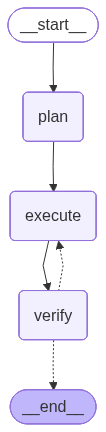

In [9]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())